<a href="https://colab.research.google.com/github/AshnakAGQ/DistractedDriver/blob/master/CS175Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

     |████████████████████████████████| 526.1MB 26kB/s 
     |████████████████████████████████| 460kB 44.7MB/s 
     |████████████████████████████████| 3.0MB 36.3MB/s 


Import image data


In [3]:
print(tf.__version__)

2.3.0-dev20200603


In [27]:
image_size = (300, 300) #image size for image net is 224 x 224 x 3
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./drive/My Drive/driver-data/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    subset = 'training',
    validation_split = 0.2
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./drive/My Drive/driver-data/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    subset = 'validation',
    validation_split = 0.2
)

Found 22433 files belonging to 10 classes.
Using 17947 files for training.
Found 22433 files belonging to 10 classes.
Using 4486 files for validation.


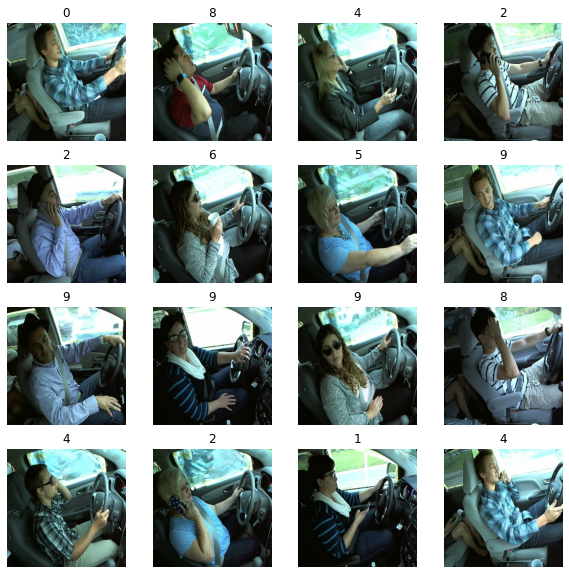

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [0]:
def crossvalidate(dataset, n_splits):

  """
  Given a dataset, splits it into {n_splits} subsets, where for 
  any given index, train_ds[i] contains all the subsets except 
  the portion in val_ds[i]

  Parameters
  ----------
  dataset : tensorflow.data.dataset
      Full dataset to split
    
  n_splits : int
      Number of splits; XFold # (at least 2 or greater)
      
  Returns
  -------
  train_ds : list (dtype=ConcatenateDataset)
      List of datasets not containing the ith portion of data
      
  val_ds : list (dtype=ShardDataset)
      List of datasets containing the ith portion of data
  
  """

  # Initialize lists
  val_ds = []
  train_ds = []

  # Create val_ds first
  for i in range(n_splits):
    val_ds.append(dataset.shard(num_shards=n_splits, index=i))

  # Create train_ds using val_ds indexes other than the current index
  for i in range(n_splits):
    if i == 0:
      train_ds.append(val_ds[1])
    else:
      train_ds.append(val_ds[0])
    for a in range(1, i):
      train_ds[i] = train_ds[i].concatenate(val_ds[a])
    for b in range(i+1, n_splits):
      if not(i==0 and b==1):
        train_ds[i] = train_ds[i].concatenate(val_ds[b])

  return train_ds, val_ds

In [7]:
n_splits = 10

train_ds, val_ds = crossvalidate(full_ds, n_splits)

print(len(train_ds), train_ds[0])
print(len(val_ds), val_ds[0])

10 <ConcatenateDataset shapes: ((None, 224, 224, None), (None,)), types: (tf.float32, tf.int32)>
10 <ShardDataset shapes: ((None, 224, 224, None), (None,)), types: (tf.float32, tf.int32)>


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [25]:
model = VGG16(include_top=False,weights='imagenet', input_shape=(300,300,3))


58892288/58889256 [==============================] - 1s 0us/step


In [32]:
flatten = Flatten()(model.outputs[-1])
output = Dense(10, activation = 'softmax')(flatten)
model = Model(inputs=model.inputs,outputs=output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

In [28]:
# it = iter(full_ds) # Dataset iterable
# images = next(it)[0].numpy() # Get first batch of images
# images = preprocess_input(images) # Preprocess images. Not sure if this necessary or not
images = train_ds
yhat = model.predict(images)

KeyboardInterrupt: ignored

In [23]:
yhat.shape

(32, 1000)